In [33]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [34]:
file_path = "20230914_processed_table.csv"
wavelength_string = 670
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[  4891.    12895.5   -8596.    13342.5    1190.5   12976.    -5411.5
  13045.    -6623.5   13368.5    2486.    12814.   -12740.5   13944.
   9496.5   12967.5  -13235.    13903.    11358.    13094.5   -8040.5
  13293.     7342.5   13117.5    -674.    12906.      334.5   13393.
   3112.    12875.5   -3963.    13650.     4450.    13125.5   -6885.5
  13580.     6726.5   12994.5   -9906.    13737.5    2201.    13172.5
  -6372.5   13278.    -6036.    13547.5    1799.5   12976.5  -12123.5
  14053.     8802.    12981.   -12333.5   13903.    10326.    13109.5
  -7081.    13226.     6317.    13089.     -227.    12805.      -70.5
  13321.5    1057.    13329.    -2102.5   13579.     8027.5   13096.5
  -9776.    13947.5    9101.    13241.   -12201.    13999.     3880.5
  13327.5   -8014.5   13505.5   -4793.5   13695.5     477.5   13135.5
 -10556.    14132.     7209.5   12967.   -10266.    13911.     8276.
  12972.    -4663.    13153.     3708.25  13091.    -2852.   

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [35]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

print(past_fit)

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta" : 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        }
    }
}

theta_pol = past_fit[0]
delta_HWP = past_fit[1]
offset_HWP = past_fit[2]
delta_derot = past_fit[3]
offset_derot = past_fit[4]
delta_opts = past_fit[5]
epsilon_opts = past_fit[6]
rot_opts = past_fit[7]
delta_FLC = past_fit[8]
rot_FLC = past_fit[9]
em_gain = past_fit[10]

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]
[ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [36]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.51859792 0.51785552 0.02773924 0.        ]
 [0.51859792 0.51785552 0.02773924 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 8576.640503544128


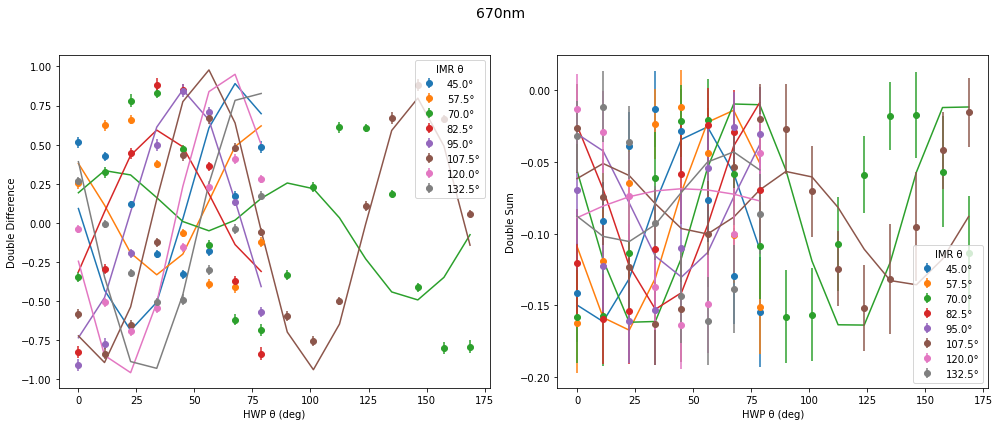

In [37]:
# Fittin for all parameters

bounds = [ 
    # (0, 2),  # em_gain
    (-2 * np.pi, 2 * np.pi), # dichroic_retardance
    (0, 1), # dichroic_diattenuation
    (-90, 90), # dichroic_rotation_angle 
    # (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    # (-5, 5),  # rot_FLC
    (-np.pi, np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    # ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    # (-1, 1),  # offset_derot
    # ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_HWP
    # (-5, 5),  # offset_HWP
    # (-5, 5),  # theta_pol
]

p0 = {
    'dichroic': {'phi': -3.1371292772000094, 'epsilon': 4.2218040168065446e-08, 'theta': 85.55977749554518}, 
     'optics': {'phi': -1.1168073038062216, 'epsilon': 0.0018033511154470858, 'theta': 26.10422388114941}
    }

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'dichroic': {'phi': -3.1371292772000094, 'epsilon': 4.2218040168065446e-08, 'theta': 85.55977749554518}, 'optics': {'phi': -1.1168073038062216, 'epsilon': 0.0018033511154470858, 'theta': 26.10422388114941}}


Iteration #: 1
logl_value: 550.2570877314294
Best Fit Parameters: [ 6.23184428e+00  2.26451257e-09  9.00000000e+01 -2.40176884e+00
  3.84395246e-03  2.73729252e+00]


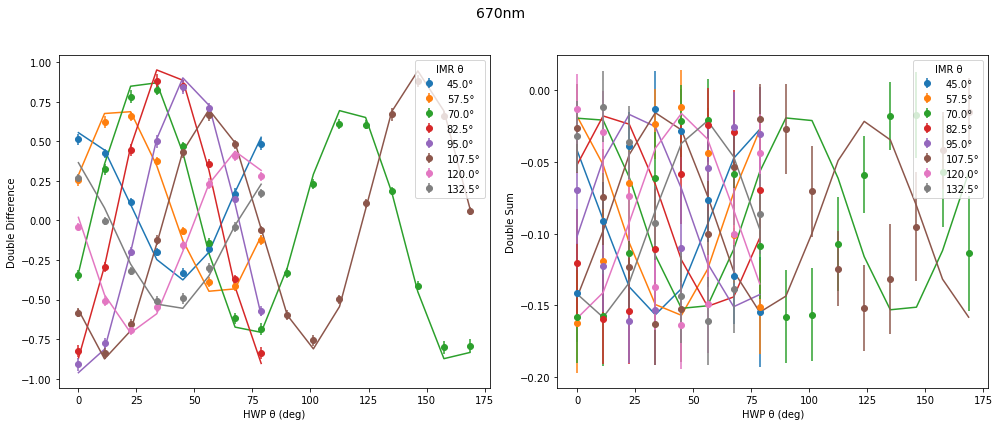

After p0: {'dichroic': {'phi': 6.2318442821984, 'epsilon': 2.264512573679286e-09, 'theta': 90.0}, 'optics': {'phi': -2.4017688366685555, 'epsilon': 0.0038439524591682176, 'theta': 2.737292516989708}}
Before p0: {'dichroic': {'phi': 6.2318442821984, 'epsilon': 2.264512573679286e-09, 'theta': 90.0}, 'optics': {'phi': -2.4017688366685555, 'epsilon': 0.0038439524591682176, 'theta': 2.737292516989708}}
Iteration #: 2
logl_value: 75.94619634225953
Best Fit Parameters: [ 5.82319262e+00  1.86161260e-09  7.99900788e+01 -2.47678273e+00
  4.74359326e-03  3.37463172e+00]


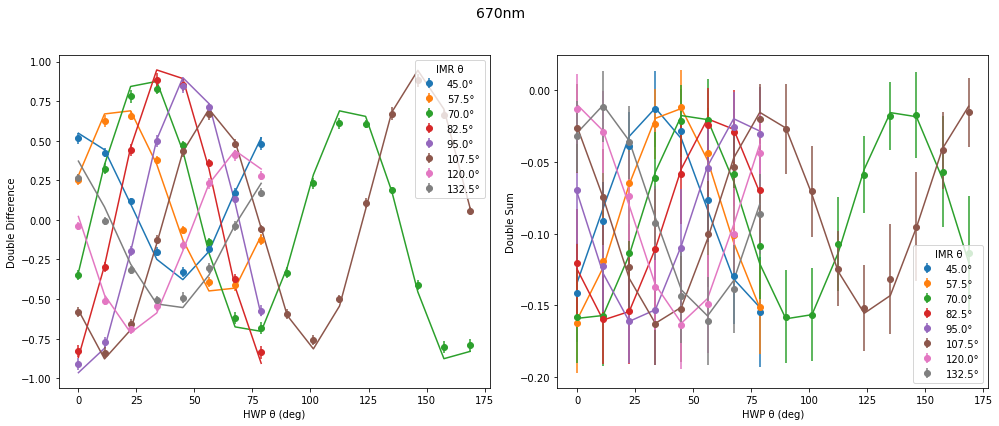

After p0: {'dichroic': {'phi': 5.823192619666663, 'epsilon': 1.8616126030973178e-09, 'theta': 79.9900788026007}, 'optics': {'phi': -2.4767827337185317, 'epsilon': 0.004743593262798791, 'theta': 3.374631724933985}}
Before p0: {'dichroic': {'phi': 5.823192619666663, 'epsilon': 1.8616126030973178e-09, 'theta': 79.9900788026007}, 'optics': {'phi': -2.4767827337185317, 'epsilon': 0.004743593262798791, 'theta': 3.374631724933985}}
Iteration #: 3
logl_value: 75.94618710455283
Best Fit Parameters: [ 5.82569368e+00  1.98054256e-09  7.99375207e+01 -2.47649230e+00
  4.73325177e-03  3.37165738e+00]


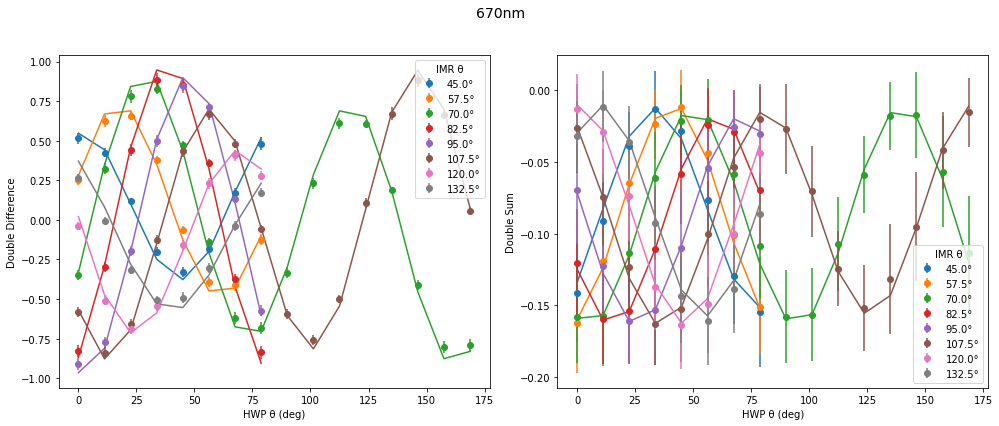

After p0: {'dichroic': {'phi': 5.82569368446504, 'epsilon': 1.9805425576416813e-09, 'theta': 79.9375206653423}, 'optics': {'phi': -2.476492298785013, 'epsilon': 0.00473325176939048, 'theta': 3.371657377970516}}


In [38]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

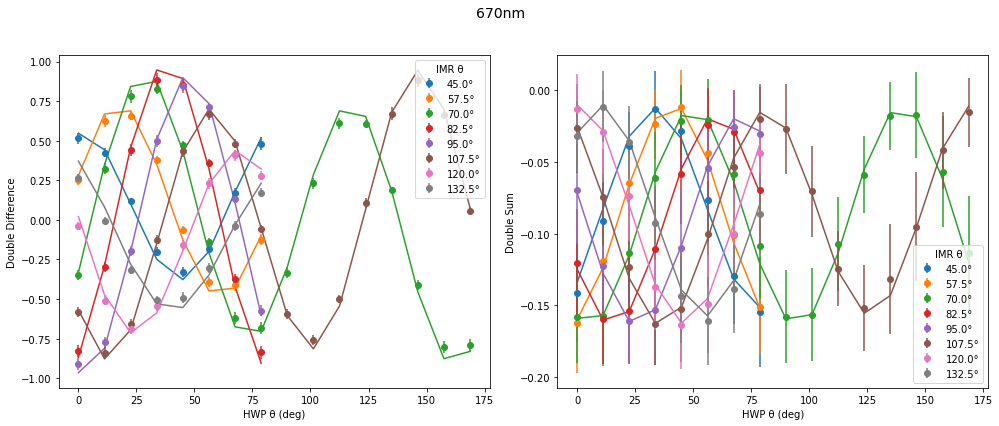

In [39]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)